In [58]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import matplotlib.pyplot as plt

In [59]:
def get_stock_data(ticker):
    stock = yf.download(ticker)
    return stock.dropna()

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
stock_data = {ticker: get_stock_data(ticker) for ticker in tickers}

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [60]:
aapl = stock_data["AAPL"]

In [69]:
aapl_close = aapl["Close"]
full_range = pd.date_range(start=aapl_close.index.min(), end=aapl_close.index.max(), freq='D')
aapl_close = aapl_close.reindex(full_range)
aapl_close.index = pd.DatetimeIndex(aapl_close.index, freq='D')
aapl_close
model = ARIMA(aapl_close, order=(1,1,2))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                15618
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -13589.626
Date:                Mon, 18 Sep 2023   AIC                          27187.251
Time:                        11:00:33   BIC                          27217.876
Sample:                    12-12-1980   HQIC                         27197.392
                         - 09-15-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8878      0.007   -133.266      0.000      -0.901      -0.875
ma.L1          0.7639      0.007    105.212      0.000       0.750       0.778
ma.L2         -0.1816      0.003    -61.497      0.000      -0.187      -0.176
sigma2         0.5926      0.002    327.616      0.000       0.589       0.596
===================================================================================
Ljung-Box (L1) (Q):                  38.30   Jarque-Bera (JB):           2995318.80
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):           27610.06   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        70.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

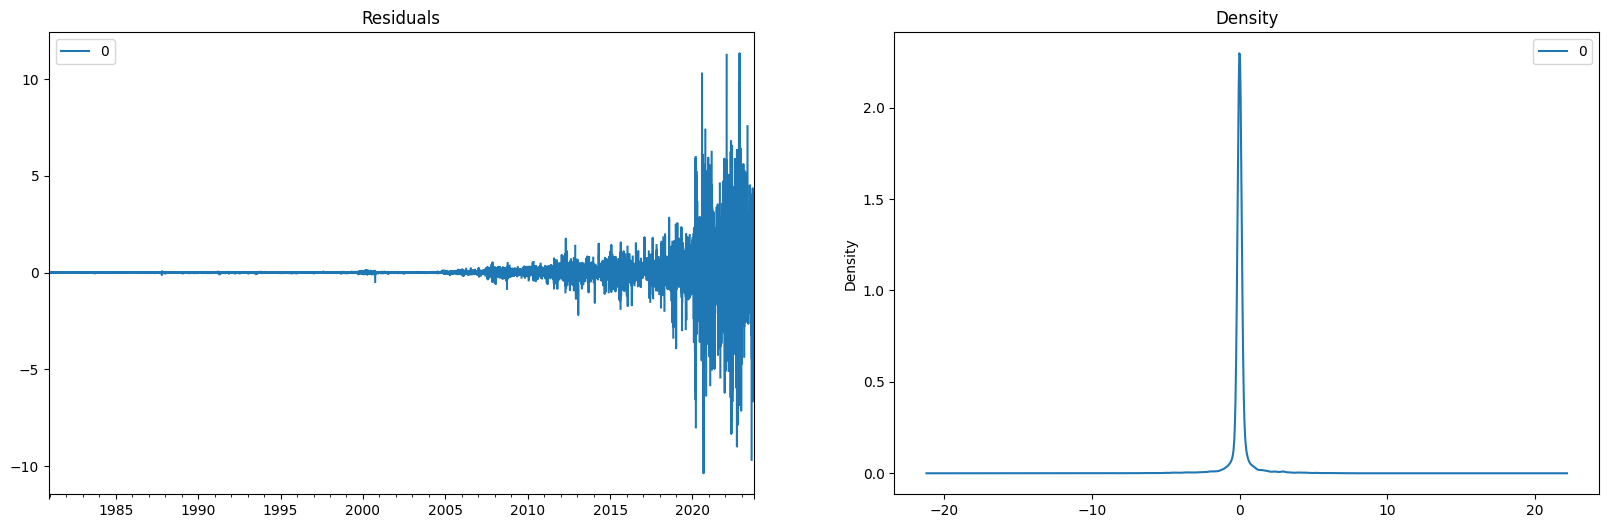

In [70]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize = (20, 6))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

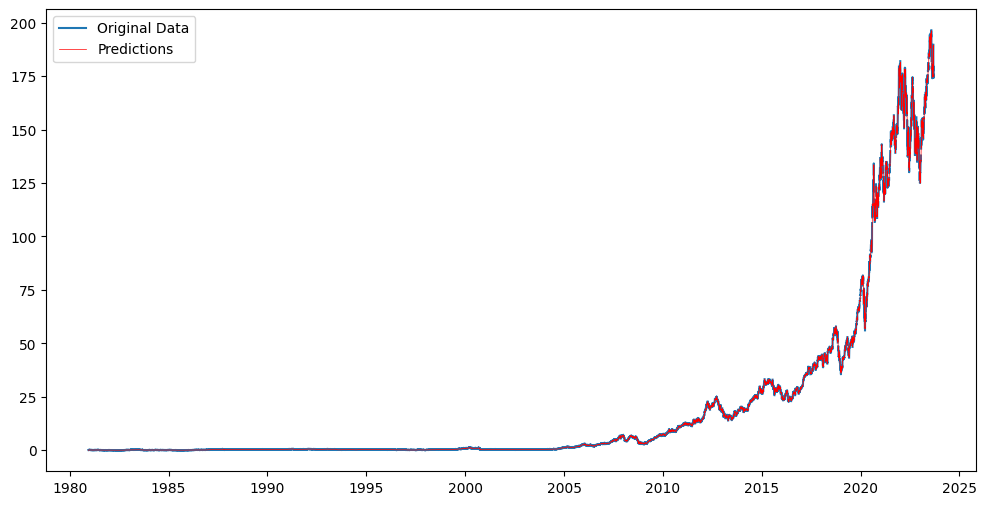

In [88]:
# Actual vs Fitted
start_point, end_point = "12-12-1980", "09-15-2023"
predicted = model_fit.predict(start=start_point, end=end_point, dynamic=False)
plt.figure(figsize=(12, 6))
plt.plot(aapl_close, label="Original Data")
plt.plot(predicted, color='red', label="Predictions", lw=0.5)
plt.legend()
plt.show()

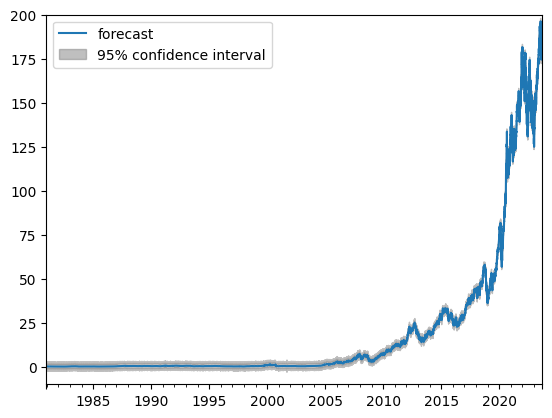

In [87]:
fig, ax = plt.subplots()
plot_predict(model_fit, start=start_point, end=end_point, dynamic=False, ax=ax)
ax.set_ylim(-10, 200)
plt.show()